### This notebook is the first step towards analyzing marine heatwaves using global sea surface temperature data

The data is cloud optimized and analysis ready thanks to Pangeo-forge using OSN.

In [1]:
# Import libraries 
import s3fs
import sys
import xarray as xr
import numpy as np


#### Import data
- load the daily NOAA OISST dataset and resample to monthly means

In [2]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},) 

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True).resample(time='MS').mean()
sst = ds.sst.isel(zlev=0).drop('zlev')
sst.load();

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


#### Decompose SST maps into mean, trend, annual, and semi-annual harmonics

In [3]:
# Transform time into decimal year 
dyr = sst.time.dt.year + (sst.time.dt.month-0.5)/12

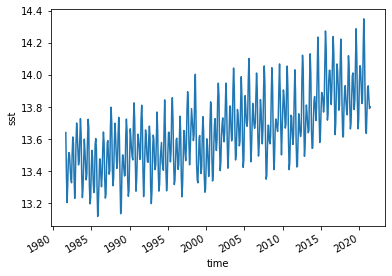

In [4]:
# Quick check: global mean SST
sst.mean(('lat','lon')).plot()

Use least-squares regression and solve for model coefficients

In [5]:
# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':sst.time.values, 'coeff':np.arange(1,7,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':sst.time.values})  

# resulting coefficients of the model
sst_mod = xr.DataArray(pmodel_da.dot(sst), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,7,1), 'lat':sst.lat.values, 'lon':sst.lon.values})


In [ ]:
# Construct mean, trend, and seasonal cycle
mean = model_da[:,0].dot(sst_mod[0,:,:])
trend = model_da[:,1].dot(sst_mod[1,:,:])
seas = model_da[:,2:].dot(sst_mod[2:,:,:])

# compute anomalies by removing all  the model coefficients 
ssta_notrend = sst-model_da.dot(sst_mod)

#### Calculate summary statistics for marine heatwaves. 

Our criteria for marine heatwaves are consecutive months where the detrended and deseasonalized SST anomalies exceeds the local 90th percentile.  

In [ ]:
# Average statistics, global maps
t90_global = ssta_notrend.quantile(.9)
mhws = ssta_notrend.where(ssta_notrend>t90_global, drop=False, other=np.nan)


In [ ]:
# Average event duration (months)
avg_duration = np.empty(mhws[0,:,:].shape); avg_duration[:]= np.nan

# Average event intensity (ºC)
avg_intensity = np.empty(mhws[0,:,:].shape); avg_intensity[:]= np.nan

# Number of total marine heatwave events
avg_count = np.empty(mhws[0,:,:].shape); avg_count[:]= np.nan

for i in range(0, mhws.shape[1]):
    for j in range(0, mhws.shape[2]):
        P = mhws[:,i,j].copy()
        P.loc[~P.isnull()] = 1  # values that are not nan will be assigned as 1.
        if np.nansum(P)==0:
            continue
        else:
            duration = P.groupby(((P.shift()!=P).cumsum())-P).count()
            # date = mhws[:,i,j].time.groupby(((P.shift() != P).cumsum())-P).mean()
            avg_duration[i,j] = float(duration.mean().values)
            avg_count[i,j] = duration.shape[0]
            
            intensity = mhws[:,i,j].groupby(((P.shift()!=P).cumsum())-P).mean()
            avg_intensity[i,j] = float(intensity.mean().values)
            

#### Save created variables to zarr

In [ ]:
# xarray Dataset to save
ds_out = xr.Dataset(
    data_vars=dict(
        mean=(['time', 'lat', 'lon'], mean.values),
        trend=(['time', 'lat', 'lon'], trend.values),
        seas=(['time', 'lat', 'lon'], seas.values),
        ssta_notrend=(['time', 'lat', 'lon'], ssta_notrend.values),
        avg_duration=(['lat', 'lon'], avg_duration.values),
        avg_count=(['lat', 'lon'], avg_count.values),
        avg_intensity=(['lat', 'lon'], avg_intensity.values), 
        
    ),
    coords=dict(
        lon=ds.lon,
        lat=ds.lat,
        time=ds.time,
    ),
    attrs=dict(description="OISST v2.1 preprocessed for Ocetrac",
              threshold='90th percentile',
              climatology='entire period'),
)
ds_out

In [ ]:
ds_out.to_zarr('preprocessed_oisst_mhw_stats.zarr')